# Introduction into Data Science - Assignment Part II

This is the second part of the assignment in IDS 2023/2024.

This part of the assignment consists of five questions — each of these questions is contained in a separate Jupyter notebook:
- [Question 1: Data Preprocessing](Q1_Preprocessing_Visualization.ipynb)
- [Question 2: Association Rules](Q2_Frequent_Itemsets_Association_Rules.ipynb)
- [Question 3: Process Mining](Q3_Process_Mining.ipynb)
- [Question 4: Text Mining](Q4_Text_Mining.ipynb)
- [Question 5: Big Data](Q5_Big_Data.ipynb)

Additional required files are in two folders.
- [datasets](datasets/)
- [scripts](scripts/)

Please use the provided notebook to work on the questions. When you are done, upload your version of each of the notebooks to Moodle. Your submission will, therefore, consist of five jupyter notebook and _no_ additional file. Any additionally provided files will not be considered in grading.
Enter your commented Python code and answers in the corresponding cells. Make sure to answer all questions in a clear and explicit manner and discuss your outputs. _Please do not change the general structure of this notebook_. You can, however, add additional markdown or code cells if necessary. Please **DO NOT CLEAR THE OUTPUT** of the notebook you are submitting! Additionally, please ensure that the code in the notebook runs if placed in the same folder as all of the provided files, delivering the same outputs as the ones you submit in the notebook. This includes being runnable in the bundled conda environment.

*Please make sure to include the names and matriculation numbers of all group members in the provided slots in each of the notebooks.* If a name or a student id is missing, the student will not receive any points.

Hint 1: **Plan your time wisely.** A few parts of this assignment may take some time to run. It might be necessary to consider time management when you plan your group work. Also, do not attempt to upload your assignment at the last minute before the deadline. This often does not work, and you will miss the deadline. Late submissions will not be considered.

Hint 2: RWTHMoodle allows multiple submissions, with every new submission overwriting the previous one. **Partial submissions are possible and encouraged.** This might be helpful in case of technical issues with RWTHMoodle, which may occur close to the deadline.

Hint 3: As a technical note. Some IDEs such as DataSpell may automatically strip jupyter notebook cell metadata. If you are able, please re-add it from the source notebooks before submission. This is necessary for our grading.

Enter your group number and members with matriculation numbers below.

In [1]:
GROUP_NO = 9 # group number
GROUP_MEMBERS = {
    459114: "Yu-Ting Huang", # mat. no. : name,
    460730: "Chieh-Ting Lin",
}

---

In [1]:
# required imports
# do not edit!

import nltk
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import unicodedata
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
snow_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

/var/folders/z9/0tfmhy656pj96ck0q5tsk6bm0000gn/T/ipykernel_72732/1010663624.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to /Users/amos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/amos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/amos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to

# Question 4: Text Mining (23 pts)


## About the Data: Taylor Swift

In this task, our data consists of song lyrics from nine albums by Taylor Swift. Taylor Swift is one of the best-selling musicians and currently subject of various research. As she is known to venture into different musical genres and make artistic innovations for each album, we want to check whether we can support this claim using Text Mining.

Therefore, we:
1. Load the data and preprocess it first,
2. use the set of words for recognizing a lyric's album,
3. use Doc2Vec to check the similarity of albums and to cluster them,
4. and finally use language models that are based on n-grams to generate some own lyrics.

We aim to support our data analysis by reporting data and discussing results. 

## Data Loading and Preprocessing (8 Pts)

### a)
i. First things first. Import the file **q4_taylor_swift.csv** and save it into a dataframe named `swift_df`. Visualize the dataframe by showing the first five lines. 

_Note: In this question, every lyric is considered as a single document. The data contains lyrics from several albums. The order of the lyrics is preserved considering their album, song and within their song._


In [2]:
# Import and visualization.
# YOUR CODE HERE
swift_df = pd.read_csv('/Users/amos/Downloads/Part_2_updated/datasets/q4_taylor_swift.csv')
swift_df.head()

,album,lyric
0,Taylor Swift,He said the way my blue eyes shined
1,Taylor Swift,Put those Georgia stars to shame that night
2,Taylor Swift,"I said, ""That's a lie"""
3,Taylor Swift,Just a boy in a Chevy truck
4,Taylor Swift,That had a tendency of gettin' stuck


ii. As a first step in preprocessing, normalize all unicode encodings using `unicodedata.normalize` with 'NKFD' as the form and remove all closing and opening brackets, i.e., '(' and ')'.

In [3]:
# YOUR CODE HERE
swift_df['lyric'].apply(lambda x: unicodedata.normalize('NFKD', x).replace('(', '').replace(')', ''))
swift_df.head()

,album,lyric
0,Taylor Swift,He said the way my blue eyes shined
1,Taylor Swift,Put those Georgia stars to shame that night
2,Taylor Swift,"I said, ""That's a lie"""
3,Taylor Swift,Just a boy in a Chevy truck
4,Taylor Swift,That had a tendency of gettin' stuck


### b)
We get a first idea of the data distribution over the albums by counting the lyrics in our data per album. Code the method `count_lyrics_per_album`.

In [4]:
def count_lyrics_per_album(input_df: pd.DataFrame) -> pd.Series:
    """ 
    Counts the lyrics for each album and stores them in a pandas series.
    :param input_df: A pandas dataframe containing album data and their lyrics.
    :return: The data containing the albums and the count of lyrics per album.
    """
    # YOUR CODE HERE
    return input_df.groupby('album').count()['lyric']

In [5]:
# Using the predefined function to calculate the series of values
count_per_album = count_lyrics_per_album(swift_df)

# Transforming the series to a dataframe for visualization - feel free to check the series object
pd.DataFrame({'album': count_per_album.index, 'lyric count': count_per_album.values})

,album,lyric count
0,1989 (Deluxe),1003
1,Fearless (Taylor’s Version),1170
2,Lover,932
3,Red (Deluxe Edition),1064
4,Speak Now (Deluxe),935
5,Taylor Swift,609
6,evermore (deluxe version),909
7,folklore (deluxe version),722
8,reputation,985


### c)
i. Next, we visualize the counted lyrics per album using a barplot. Write down your code in `plot_lyric_count`.

In [6]:
def plot_lyric_count(input_series: pd.Series):
    """ 
    Visualizes the number of lyrics for each album in a bar plot.
    :param input_series: A pandas series containing album data and their lyric counts.
    """
    # YOUR CODE HERE
    fig = sns.barplot(x=input_series.index, y=input_series.values)
    fig.axhline(input_series.mean(), color='r', linestyle='--')
    fig.set_xticklabels(input_series.index, rotation=90)
    

/var/folders/z9/0tfmhy656pj96ck0q5tsk6bm0000gn/T/ipykernel_72732/3133627907.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(input_series.index, rotation=90)


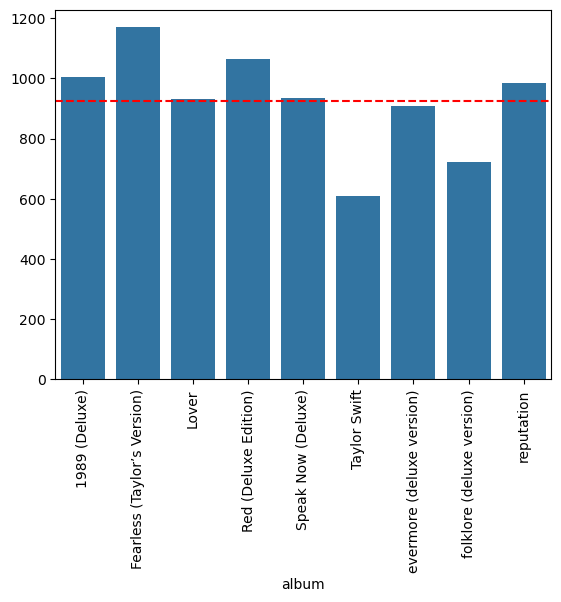

In [7]:
# Visualizing the data of 'count_per_album' as a bar plot using your function
plot_lyric_count(count_per_album)

ii. Is the data balanced enough for album classification?

__Student Answer:__ It's not very balanced, with the number of lyrics for the albums "Taylor Swift" and "folklore" significantly lower than the other albums.

### d)
In the following, we want to remove duplicate lyrics, as a song may contain a lyric more than once. Removing duplicates improves the interpretability of the further analysis and reduces an overfitting of the classification task on the duplicated lyrics. 

i. Therefore, as a first step, we remove all duplicate lyrics and keep only a single instance per duplicate lyric on each album. The obtained dataset has to be named `swift_df_proc`.

In [8]:
# Dropping all duplicates of a lyric on an album
# YOUR CODE HERE
swift_df_proc = swift_df.drop_duplicates(subset=['album', 'lyric']).copy()
swift_df_proc.reset_index(inplace=True, drop=True)
count_lyrics_per_album(swift_df_proc)

album
1989 (Deluxe)                  591
Fearless (Taylor’s Version)    830
Lover                          636
Red (Deluxe Edition)           671
Speak Now (Deluxe)             682
Taylor Swift                   402
evermore (deluxe version)      639
folklore (deluxe version)      563
reputation                     604
Name: lyric, dtype: int64

ii. Do lyrics occur in several albums? If this is the case, remove them entirely as such a lyric is not suitable for our further questions. If this is not the case, give the code that shows so. Remember also to give a clear answer below. 

In [9]:
# YOUR CODE HERE
ununique_lyrics = swift_df_proc[swift_df_proc.duplicated(subset=['lyric'], keep=False)]

if ununique_lyrics.empty:
    print('No duplicates found')
else:
    swift_df_proc.drop(ununique_lyrics.index, inplace=True)
    swift_df_proc.reset_index(inplace=True, drop=True)

__Student Answer:__ Yes, some lyrics are repeated in multiple albums, but I have already removed them.

/var/folders/z9/0tfmhy656pj96ck0q5tsk6bm0000gn/T/ipykernel_72732/3133627907.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(input_series.index, rotation=90)


album
1989 (Deluxe)                  588
Fearless (Taylor’s Version)    825
Lover                          633
Red (Deluxe Edition)           666
Speak Now (Deluxe)             679
Taylor Swift                   400
evermore (deluxe version)      636
folklore (deluxe version)      562
reputation                     603
Name: lyric, dtype: int64

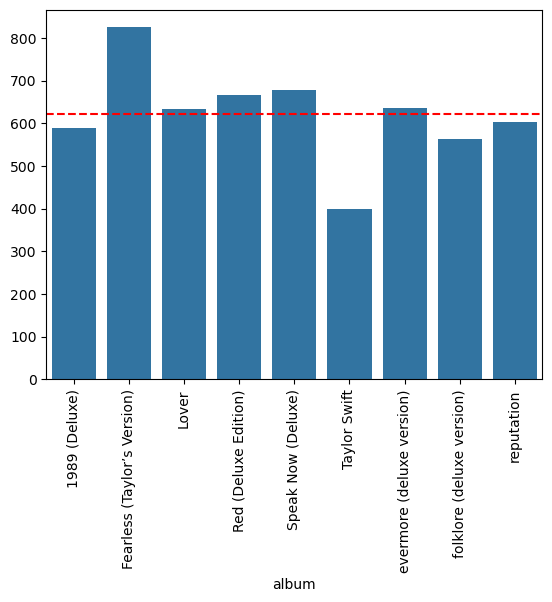

In [10]:
plot_lyric_count(count_lyrics_per_album(swift_df_proc))
count_lyrics_per_album(swift_df_proc)

### e)
The following tasks are more related to the preprocessing that has to be applied for the Text Mining context. First of all, we have to create a corpus. The obtained corpus should be named `corpus`. Make sure that each document in the corpus corresponds to exactly one lyric in `swift_df_proc`. 

In [11]:
# Creating the corpus
# YOUR CODE HERE
corpus = swift_df_proc['lyric'].tolist()

### f)
Use the skeleton of the function `preprocessor_func` below to create a function that applies tokenization, stopword removal and lemmatization to an input string. The remaining tokens (after stopword removal and lemmatization) should be joined using a whitespace (' ').

_Note: To keep the complexity low, we do not expect you to use POS tagging before lemmatizing. You can apply lemmatization only for the nouns. This is covered by using a lemmatizer without further arguments._

In [12]:
def preprocessor_func(text: str) -> str:
    """
    Preprocesses a string using tokenization, stopword removal and lemmatization.
    :param text: A string to be preprocessed.
    :return: A joined string resulting from tokenization, stopword removal and lemmatization of an input string.
    """
    # YOUR CODE HERE
    tokens = reg_tokenizer.tokenize(text.lower())
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens if t.lower() not in stopword_list]
    return ' '.join(tokens)

### g)
Now, create a preprocessed corpus `corpus_proc` by applying the preprocessing function to your corpus. For some tasks, we have to use the preprocessed corpus, and for some, the original corpus. This is indicated for each task.

In [13]:
# Corpus preprocessing
# YOUR CODE HERE
corpus_proc = [preprocessor_func(text) for text in corpus]

### h)
In this task, we create all preprocessed data for all remaining tasks within the Text Mining question exercise.
For the later application of the set of words, we need to split the corpus.
First, we need to split our input data into a train and test set according to the Pareto rule (80% training set size and 20% test set size).
Therefore, split the dataframe `swift_df_proc` into a training and test set using the variable identifiers `df_train`, `df_test`, `y_train`, and `y_test`.
Further, make sure that distribution based on the "album" value is preserved.

In [14]:
# YOUR CODE HERE
df_train, df_test = train_test_split(swift_df_proc, test_size=0.2, stratify=swift_df_proc['album'])
y_train, y_test = df_train['album'], df_test['album']

### i)
Lastly, we create two further corpora, `corpus_train` and `corpus_test`, using the split data and the identical approach that is used before.

In [15]:
# YOUR CODE HERE
corpus_train, corpus_test = df_train['lyric'].tolist(), df_test['lyric'].tolist()

## Set of Words (6.5 Pts)

In this subtask, we use the set of words technique to distinguish and recognize different lyrics based on which album they belong to. Set of words encodes the documents by indicating for each word in our vocabulary whether the word occurs in the sentence or not.

### j)
Create a set of words encoding for the whole corpus. Use the previously defined preprocessor function `preprocessor_func` for our corpus `corpus`. 

In [16]:
# Creating a set of words using the propressor function and the corpus
# YOUR CODE HERE
sow = CountVectorizer(binary=True, preprocessor=preprocessor_func)
sow.fit(corpus)


CountVectorizer(binary=True,
                preprocessor=<function preprocessor_func at 0x13d36db80>)

### k)
In the following, we want to have a first look at how the set of words classification works. Therefore, we apply the set of words to a line in the `swift_df`. Use the `apply_sow_to_line_by_index` function that is given an index of a lyric and that returns the original line, its preprocessed form, and its encoding resulting from the set of words implementation.
Comment below on what information the set of words representation contains.

In [17]:
def apply_sow_to_lyric_by_index(index: int) -> (str, str, _):
    """ 
    Applies set of words to a lyric in the swift_df.
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    # YOUR CODE HERE
    lyric = swift_df.iloc[index]['lyric']
    lyric_proc = preprocessor_func(lyric)
    lyric_sow = sow.transform([lyric]).toarray()
    return lyric, lyric_proc, lyric_sow

In [18]:
# YOUR CODE HERE
index = 2

In [19]:
line, line_p, line_sow = apply_sow_to_lyric_by_index(index)
print('Original line:     ', line)
print('Preprocessed line: ', line_p)
print('SoW encoding:\n', line_sow)

Original line:      I said, "That's a lie"
Preprocessed line:  said lie
SoW encoding:
 [[0 0 0 ... 0 0 0]]


__Student Answer:__ After processing, all special characters and stopwords have been removed. Nouns have been reduced to their singular form. Even if a sentence contains many identical words, they have been reduced to one due to the use of sets. Finally, All resulting values are either 0 or 1. 

### l)
In this subtask, we use a **S**tochastic **G**radient **D**escent classifier to predict the album given a lyric for the corpus. Therefore, the steps to follow are briefly described below:
 1. First, we create a set of words encoding for the whole corpus. As we want to evaluate our results later using the test set, restrict yourself in the training to only use the training set `corpus_train`. 
 2. Train the classifier on the training set with 'album' as the target feature and 'log_loss' as the loss function.
 3. Predict the album for each line in the training and test set `corpus_test`.
 4. Calculate and show the accuracy for both the training and test set and store them in the variables `accuracy_train` and `accuracy_test`.

In [20]:
# Creating the set of words encoding
# YOUR CODE HERE
X_train = sow.transform(corpus_train)

In [21]:
# Train the classifier
# YOUR CODE HERE
classifier = SGDClassifier(loss='log_loss')
classifier.fit(X_train, y_train)

SGDClassifier(loss='log_loss')

In [22]:
# Predict the album
# YOUR CODE HERE
X_test = sow.transform(corpus_test)
y_test_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)

In [23]:
# Compute and show accuracy for training and test set
# YOUR CODE HERE
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train, accuracy_test

(0.758998435054773, 0.35031277926720283)

### m)
Given the accuracy values that you calculated in the last subtask, argue about the classifier's accuracy compared to a most frequent guessing classifier (i.e., a classifier that always chooses to predict the most frequent album). Use the distribution of lyrics over the albums calculated in task **d)** to support your argument. 

__Student Answer:__ In the previous data visualization, we observed that the lyrics for the most common albums account for approximately `15%` of the total among these nine albums. When using the SGD classifier with a set of words, the accuracy is approximately `35%`, which is `better` than randomly guessing the most common album

### n)
Next, we want to make our results more visual. Therefore, implement the `pred_album_by_index` method that takes a lyric's index from the `swift_df` dataframe as input, and based on that, returns the corresponding lyric, its actual album and its predicted album using the SGD classifier from **l)**.

In [24]:
def pred_album_by_index(index: int) -> (str, str, str):
    """ 
    Predicts a lyric's album based on the .
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    # YOUR CODE HERE
    lyric, album = swift_df.iloc[index][['lyric', 'album']]
    album_pred = classifier.predict(sow.transform([lyric]))[0]
    return lyric, album, album_pred

In [25]:
index = 1000 # Please change the index and do not use -1

In [26]:
lyric, album_actual, album_pred = pred_album_by_index(index)

print("Lyric:          ", lyric)
print("Actual album:   ", album_actual)
print("Predicted album:", album_pred)

Lyric:           You had me crawling for you, honey
Actual album:    Fearless (Taylor’s Version)
Predicted album: reputation


## Doc2Vec (4.5 pts)

In this subtask, we encode lyrics using Doc2Vec. Given the embedding, we reduce its dimensionality using **P**rincipal **C**omponent **A**nalysis while preserving the maximum amount of information so that we can visualize and cluster the embeddings in a scatter plot. Lastly, we have a manual look at the clusters to evaluate the information gain of the Doc2Vec approach.

### o) 
Initialize and train a Doc2Vec model based on the documents in the preprocessed corpus `corpus_p`. Set `epochs=100` for the training of the model. Set the vector dimension to 20 and min_count to 3.

In [32]:
# Calculating the number of cores available
cores = multiprocessing.cpu_count()

# YOUR CODE HERE
docs = [TaggedDocument(reg_tokenizer.tokenize(doc), [i]) for i, doc in enumerate(corpus_proc)]

doc2vec = Doc2Vec(epochs=100, vector_size=20, min_count=3, workers=cores)
doc2vec.build_vocab(docs)
doc2vec.train(corpus_iterable=docs, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

### p)
Create an embedding for each lyric in `swift_df_proc` and add all embeddings inferred to the `lyric_embeddings` list. This is a pretask for the next step that we take. 

In [33]:
lyric_embeddings = []

# YOUR CODE HERE
for lyric in swift_df_proc['lyric'].tolist():
    lyric_embeddings.append(doc2vec.infer_vector(reg_tokenizer.tokenize(preprocessor_func(lyric))))

### q)
Store the data contained in `lyric_embeddings` in a dataframe `embeddings_df`.
Apply DBSCAN with euclidean distance to the `embeddings_df`dataframe with `eps = 0.3` and `min_samples = 2` and create a scatterplot with seaborn that shows the clusters of the inferred vectors. To be able to visualize the data in a two-dimensional vector space, apply a **p**rinciple **c**omponent **a**nalysis that is able to reduce the dimensionality of input data. (You can learn more about the PCA in its [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). The code for the PCA is provided.

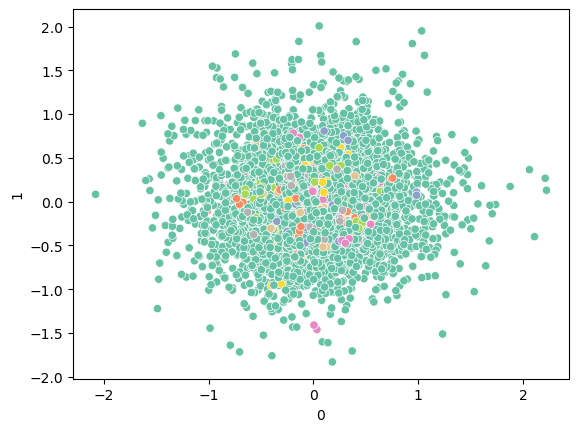

In [37]:
# YOUR CODE HERE
embeddings_df = pd.DataFrame(lyric_embeddings)
cluster = DBSCAN(eps=0.3, min_samples=2, metric='euclidean').fit_predict(embeddings_df)

# Applying PCA to the embedding reducing the dimensionality to two
pca = PCA(n_components=2)
pca_embeddings = pd.DataFrame(pca.fit_transform(embeddings_df))

# YOUR CODE HERE
sns.scatterplot(data=pca_embeddings, x=0, y=1, hue=cluster, palette='Set2').legend_.remove()

### r)
Show lyrics from the original `swift_df` dataframe contained in two distinct clusters using the two cells below. Answer separately, whether you consider the lyrics in each cluster to be similar or dissimilar.

_Note: You do not have to find exactly two clusters. Having at least two clusters, you should show the lyrics from two distinct clusters._ 

In [45]:
# Lyrics contained in one cluster
# YOUR CODE HERE
swift_df_proc[cluster == 8]['lyric'].head(10)

68          Everything that we should be
345         But you are everything to me
383     And everything that we should be
493        But you were everything to me
1687              From everything we had
Name: lyric, dtype: object

In [54]:
# Lyrics contained in one cluster
# YOUR CODE HERE
swift_df_proc[cluster == 0]['lyric'].head(10)

8     But when you think Tim McGraw
16        When you think Tim McGraw
30       "When you think Tim McGraw
Name: lyric, dtype: object

__Student Answer:__ Cluster 8 are lyrics containing the word "everything," and Cluster 0 contains lyrics is similar.


## An N-Gram Based Language Model (4 Pts)

In this subtask, we use the `swift_df` data to create an n-gram based language model to generate new lyrics. Therefore, we play around with different values for n.

### s)
Write the `lyric_preprocessor` method that takes a lyric as input and that tokenizes it and makes each word lowercase.

In [55]:
def lyric_preprocessor(lyric: str) -> [str]:
    """
    Tokenizes a lyric and makes the tokens lowercase.
    :param lyric: A string containing an input lyric.
    :return: A list containing lowercase tokens of the input lyric.
    """
    # YOUR CODE HERE
    return reg_tokenizer.tokenize(lyric.lower())

### t)
Apply the lyric_preprocessor to all lyrics in the `swift_df` and store the data in a `lyric_corpus` variable.

In [56]:
# YOUR CODE HERE
lyric_corpus = [lyric_preprocessor(lyric) for lyric in swift_df['lyric'].tolist()]

Next, train two n-grams with $n \in \{2,5\}$ on the lyric_corpus.

In [57]:
# YOUR CODE HERE
MLE2 = MLE(2)
MLE2.fit(*padded_everygram_pipeline(2, lyric_corpus))

MLE5 = MLE(5)
MLE5.fit(*padded_everygram_pipeline(5, lyric_corpus))

### u)
i. Write the `generate_lyrics` method that takes an n-gram model and an integer for the number of lyrics to be generated as input and that returns a list of new lyrics that were generated using the given n-gram model.

_Reminder / Hints: A lyric generated by an n-gram starts with n-1 times the start token "\<s>" and ends with n-1 times the end token "\</s>". Further, the n value of an n-gram can be accessed using the `n-gram.order` variable of an `n-gram`. Additionally keep in mind that you can condition the generation of your n-gram on some preceding text._

In [58]:
def generate_lyrics(n_gram_model:MLE, numb_of_new_lyrics: int) -> [str]:
    """
    Uses an n-gram model to generate several new lyrics.
    :param n_gram_model: An n-gram model. 
    :param numb_of_new_lyrics: The number of lyrics to be created.
    :return: As many generated lyrics as defined by the numb_of_new_lyrics.
    """
    # YOUR CODE HERE
    generated_lyrics = []

    for _ in range(numb_of_new_lyrics):
        generated_lyric = ["<s>"] * (n_gram_model.order - 1)
        
        while True:
            next_word = n_gram_model.generate(1, text_seed=generated_lyric)
            
            if next_word == "</s>":
                break
            
            generated_lyric.append(next_word)
        
        # 將生成的歌詞轉換為字符串並添加到列表中
        generated_lyrics.append(" ".join(generated_lyric[n_gram_model.order - 1:]))

    return generated_lyrics

ii. Generate with the first and the second model ten lyrics each. Name one difference that you can find between the lyrics generated with 2-gram model and with the 5-gram model.

In [59]:
# Generate and show ten lyrics with the first model
# YOUR CODE HERE
generate_lyrics(MLE2, 10)

['ever grow up',
 'saw it used to you',
 'i greet you follow you forget you i m pacing the only bought this way home stay stay this simple',
 'come on your eyes meet you are for the flood carry away with our love you hang on the reason to see it was drowning that i miss here forever and i forgot that s what a heartbeat',
 'you were white',
 'you ll be the great divide',
 'eeh ooh ooh ooh ooh ooh ah',
 'there s all was drowning you said leave my baby it proudly',
 'take the start a mad love this is ours is not his school girl',
 'a saint and you were you break']

In [60]:
# Generate and show ten lyrics with the first model
# YOUR CODE HERE
generate_lyrics(MLE5, 10)

['oh all you had to do was stay oh',
 'your opal eyes are all i wish to see',
 'you know the greatest films of all time were never made',
 'and they re all standing around me singing',
 'and we ll sing hallelujah we ll sing hallelujah we ll sing hallelujah we sang hallelujah',
 'with your face and the beautiful eyes',
 'i say there s nothing you can say',
 'give him all her love',
 'i don t wanna share',
 'never wanted love']

__Student Answer:__ According to the results, it seems that MLE5 performs a bit better than MLE2.